100%|██████████| 1000/1000 [00:02<00:00, 381.30it/s]


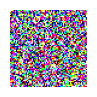

100%|██████████| 1000/1000 [00:02<00:00, 382.42it/s]


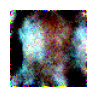

100%|██████████| 1000/1000 [00:02<00:00, 384.25it/s]


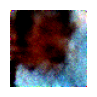

100%|██████████| 1000/1000 [00:02<00:00, 384.58it/s]


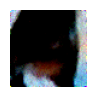

100%|██████████| 1000/1000 [00:02<00:00, 390.80it/s]


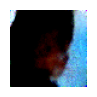

100%|██████████| 1000/1000 [00:02<00:00, 389.44it/s]


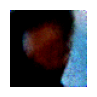

100%|██████████| 1000/1000 [00:02<00:00, 385.59it/s]


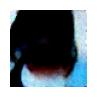

100%|██████████| 1000/1000 [00:02<00:00, 388.58it/s]


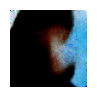

100%|██████████| 1000/1000 [00:02<00:00, 390.81it/s]


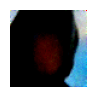

100%|██████████| 1000/1000 [00:02<00:00, 387.05it/s]


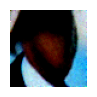

100%|██████████| 1000/1000 [00:02<00:00, 380.86it/s]


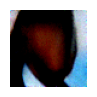

100%|██████████| 1000/1000 [00:02<00:00, 380.82it/s]


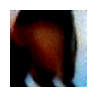

100%|██████████| 1000/1000 [00:02<00:00, 382.29it/s]


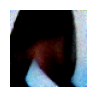

100%|██████████| 1000/1000 [00:02<00:00, 385.66it/s]


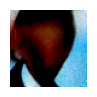

100%|██████████| 1000/1000 [00:02<00:00, 381.70it/s]


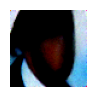

100%|██████████| 1000/1000 [00:02<00:00, 379.43it/s]


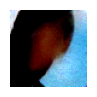

100%|██████████| 1000/1000 [00:02<00:00, 386.13it/s]


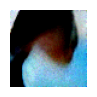

100%|██████████| 1000/1000 [00:02<00:00, 387.96it/s]


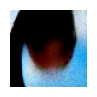

100%|██████████| 1000/1000 [00:02<00:00, 385.19it/s]


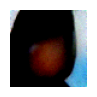

100%|██████████| 1000/1000 [00:02<00:00, 387.50it/s]


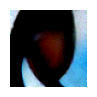

100%|██████████| 1000/1000 [00:02<00:00, 389.41it/s]


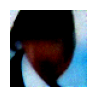

100%|██████████| 1000/1000 [00:02<00:00, 389.99it/s]


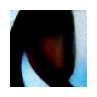

100%|██████████| 1000/1000 [00:02<00:00, 387.82it/s]


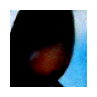

100%|██████████| 1000/1000 [00:02<00:00, 388.01it/s]


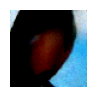

100%|██████████| 1000/1000 [00:02<00:00, 388.17it/s]


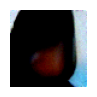

100%|██████████| 1000/1000 [00:02<00:00, 388.46it/s]


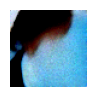

100%|██████████| 1000/1000 [00:02<00:00, 387.86it/s]


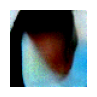

100%|██████████| 1000/1000 [00:02<00:00, 390.52it/s]


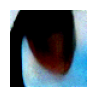

100%|██████████| 1000/1000 [00:02<00:00, 388.63it/s]


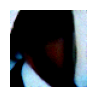

100%|██████████| 1000/1000 [00:02<00:00, 391.76it/s]


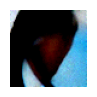

100%|██████████| 1000/1000 [00:02<00:00, 388.98it/s]


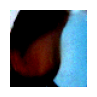

100%|██████████| 1000/1000 [00:02<00:00, 390.19it/s]


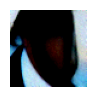

100%|██████████| 1000/1000 [00:02<00:00, 389.08it/s]


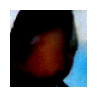

100%|██████████| 1000/1000 [00:02<00:00, 389.43it/s]


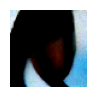

100%|██████████| 1000/1000 [00:02<00:00, 385.85it/s]


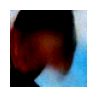

100%|██████████| 1000/1000 [00:02<00:00, 381.68it/s]


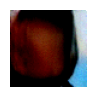

100%|██████████| 1000/1000 [00:02<00:00, 380.92it/s]


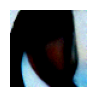

100%|██████████| 1000/1000 [00:02<00:00, 385.31it/s]


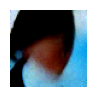

100%|██████████| 1000/1000 [00:02<00:00, 376.93it/s]


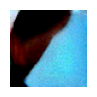

100%|██████████| 1000/1000 [00:02<00:00, 379.51it/s]


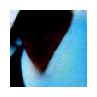

100%|██████████| 1000/1000 [00:02<00:00, 382.66it/s]


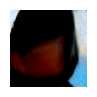

In [7]:
import math
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm
from PIL import Image

img_size = 48
batch_size = 128
num_timesteps = 1000
epochs = 10
lr = 1e-4
device = 'cuda'


def show_images(images, rows=1, cols=1):
    fig = plt.figure(figsize=(cols, rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, i + 1)
            plt.imshow(images[i], cmap='gray')
            plt.axis('off')
            i += 1
    plt.show()

# 位置编码部分
def _pos_encoding(time_idx, output_dim, device='cpu'):
    t, D = time_idx, output_dim
    v = torch.zeros(D, device=device)

    i = torch.arange(0, D, device=device)
    div_term = torch.exp(i / D * math.log(10000))

    v[0::2] = torch.sin(t / div_term[0::2])
    v[1::2] = torch.cos(t / div_term[1::2])
    return v

def pos_encoding(timesteps, output_dim, device='cpu'):
    batch_size = len(timesteps)
    device = timesteps.device
    v = torch.zeros(batch_size, output_dim, device=device)
    for i in range(batch_size):
        v[i] = _pos_encoding(timesteps[i], output_dim, device)
    return v

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_embed_dim):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
        self.mlp = nn.Sequential(
            nn.Linear(time_embed_dim, in_ch),
            nn.ReLU(),
            nn.Linear(in_ch, in_ch)
        )

    def forward(self, x, v):
        N, C, _, _ = x.shape
        v = self.mlp(v)
        v = v.view(N, C, 1, 1)
        y = self.convs(x + v)
        return y

class UNet(nn.Module):
    def __init__(self, in_ch=3, time_embed_dim=100):
        super().__init__()
        self.time_embed_dim = time_embed_dim

        self.down1 = ConvBlock(in_ch, 64, time_embed_dim)
        self.down2 = ConvBlock(64, 128, time_embed_dim)
        self.bot1 = ConvBlock(128, 256, time_embed_dim)
        self.up2 = ConvBlock(128 + 256, 128, time_embed_dim)
        self.up1 = ConvBlock(128 + 64, 64, time_embed_dim)
        self.out = nn.Conv2d(64, in_ch, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

    def forward(self, x, timesteps):
        v = pos_encoding(timesteps, self.time_embed_dim, x.device)

        x1 = self.down1(x, v)
        x = self.maxpool(x1)
        x2 = self.down2(x, v)
        x = self.maxpool(x2)

        x = self.bot1(x, v)

        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x, v)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up1(x, v)
        x = self.out(x)
        return x


class Diffuser:
    def __init__(self,
        num_timesteps=1000, # 时间步T=1000
        beta_start=0.0001, # 方差的起始值β_0 = 0.0001
        beta_end=0.02, # 方差的最终值β_T = 0.02
        device='cpu'
    ):
        self.num_timesteps = num_timesteps
        self.device = device
        # 方差调度计划
        self.betas = torch.linspace(
            beta_start,
            beta_end,
            num_timesteps,
            device=device
        )
        # α_t = 1 - β_t
        self.alphas = 1 - self.betas
        # α_bar_t = α_t * α_{t-1} * ... * α_1
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x_0, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1  # alpha_bars[0] is for t=1
        alpha_bar = self.alpha_bars[t_idx]  # (N,)
        N = alpha_bar.size(0)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)  # (N, 1, 1, 1)

        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 \
            + torch.sqrt(1 - alpha_bar) * noise
        return x_t, noise

    def denoise(self, model, x, t):
        """去除一步噪声"""
        # x_t, t
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1  # alphas[0] is for t=1
        alpha = self.alphas[t_idx]
        alpha_bar = self.alpha_bars[t_idx]
        alpha_bar_prev = self.alpha_bars[t_idx-1]

        N = alpha.size(0)
        alpha = alpha.view(N, 1, 1, 1)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        alpha_bar_prev = alpha_bar_prev.view(N, 1, 1, 1)

        model.eval()
        with torch.no_grad():
            eps = model(x, t)
        model.train()

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0  # no noise at t=1

        mu = (x - ((1-alpha) / torch.sqrt(1-alpha_bar)) * eps) \
           / torch.sqrt(alpha)
        std = torch.sqrt(
            (1-alpha) * (1-alpha_bar_prev) / (1-alpha_bar)
        )
        # x_{t-1}
        return mu + noise * std

    def reverse_to_img(self, x):
        x = x * 255
        x = x.clamp(0, 255)
        x = x.to(torch.uint8)
        x = x.cpu()
        to_pil = transforms.ToPILImage()
        return to_pil(x)

    def sample(self, model, x_shape=(1, 3, 64, 64)):
        """从纯噪声图片x_1000反向扩散出x_0"""
        batch_size = x_shape[0]
        # 采样一张白噪声图片x_1000出来
        x = torch.randn(x_shape, device=self.device)
        # for t = T, T-1, ..., 0
        for i in tqdm(range(self.num_timesteps, 0, -1)):
            t = torch.tensor(
                [i] * batch_size,
                device=self.device,
                dtype=torch.long
            )
            # 一步去噪，x_t --> x_{t-1}
            x = self.denoise(model, x, t)

        images = [
            self.reverse_to_img(x[i])
            for i in range(batch_size)
        ]
        return images


photo_path = "/root/zhangyf/multimodal/chapter03//trump3.jpeg" #replace it with your photo
image = Image.open(photo_path)

IMAGE_SHAPE = (128,128)
transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE), # Resize the input image
    transforms.ToTensor(), # Convert to torch tensor (scales data into [0,1])
    transforms.Lambda(lambda t: (t * 2) - 1), # Scale data between [-1, 1]
])

transformed_image = transform(image).to(device)

diffuser = Diffuser(num_timesteps, device=device)
model = UNet()
model.to(device)
optimizer = Adam(model.parameters(), lr=lr)

losses = []
for epoch in range(8000):
    loss_sum = 0.0

    # 每个 epoch 都生成采样的图像 =======================
    if epoch % 200 == 0:
        images = diffuser.sample(model)
        show_images(images)
    # ================================================

    batch = torch.stack([transformed_image] * batch_size)
    # t = torch.randint(0, 1000, (batch_size,), device=device).long()

    optimizer.zero_grad()
    x = batch.to(device)
    # 随机取一个时间步
    t = torch.randint(1, num_timesteps+1, (len(x),), device=device)
    # x_noisy是x_t，noise是添加的真正的噪声
    x_noisy, noise = diffuser.add_noise(x, t)
    # 模型根据x_t和时间步t，预测给x_t添加的噪声
    noise_pred = model(x_noisy, t)
    # 添加的真实噪声和预测噪声之间进行均方误差计算
    loss = F.mse_loss(noise, noise_pred)

    loss.backward()
    optimizer.step()

    loss_sum += loss.item()

# 从完全噪声的图片反向扩散
images = diffuser.sample(model)
show_images(images)